# Optimal Map Between Normal and Swiss-Roll Distributions
In this notebook, we show how one can use the numpy-implementation of the collision-based dynamics to find the optimal map between 2D normal and Swiss roll distributions. 

First, we import libraries:

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src/collisional_ot/numpy'))
sys.path.append(src_path)
from collision_numpy import collOT_numpy as collOT

rng = np.random.seed(0)

Then, we generate samples of both marginals:

In [2]:
def swissroll(n=1000, noise=0.5):
    # Generate random values for the angle (theta) and height (z)
    theta = (3 * np.pi / 2) * (1 + 2 * np.random.rand(n, 1))  # Angle (theta) values for the spiral

    # Generate the (x, y) coordinates
    x = theta * np.cos(theta)
    y = theta * np.sin(theta)

    # Add Gaussian noise
    x += noise * np.random.randn(n, 1)
    y += noise * np.random.randn(n, 1)

    # Combine the coordinates into a matrix X
    X = np.hstack((x / 5., y / 5.))  # Dividing by 5 to match the scale

    return X

Text(0.5, 1.0, 'SwissRoll')

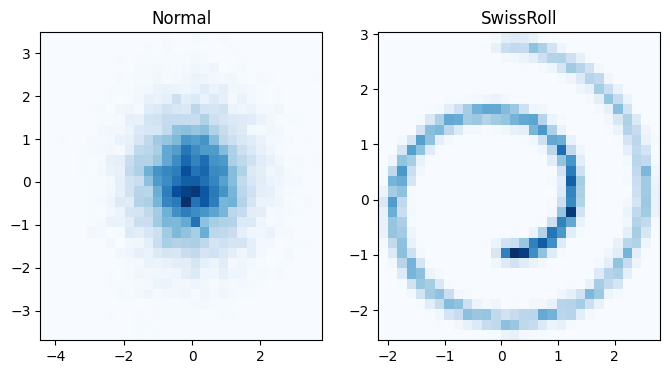

In [3]:
K = 2 # number of marginals
Np = 10000 # number of samples per marginals
n = 2 # dimension of each sample

X = np.zeros((2,Np,2))
X[0,...] = np.random.normal(0,1,(Np,2))
X[1,...] = swissroll(Np,noise=0.5)
X00 = X.copy()

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].hist2d(X[0,:,0], X[0,:,1], bins=30, cmap='Blues')
axes[0].set_title("Normal")

axes[1].hist2d(X[1,:,0], X[1,:,1], bins=30, cmap='Blues')
axes[1].set_title("SwissRoll")

## Collision-based dynamics
We call 'collOT_numpy(.)' to find the optimal paring between samples of marginals

Text(0, 0.5, '$\\mathbb{E}[||X_t^{(1)}-X_t^{(2)}||_2^2]$')

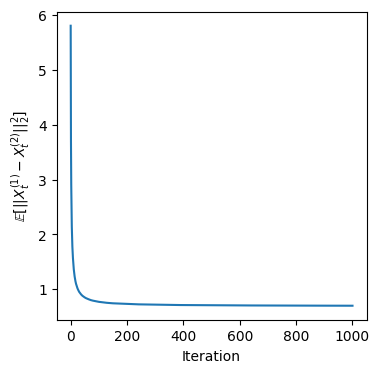

In [4]:
X = X00.copy()
X, dists_coll_xy, nt = collOT(X, MinIter=100, MaxIter=1000, tol = 1e-6, avg_window=20)

fig, ax = plt.subplots(figsize=(4,4))
ax.plot(dists_coll_xy)
ax.set_xlabel("Iteration")
ax.set_ylabel(r"$\mathbb{E}[||X_t^{(1)}-X_t^{(2)}||_2^2]$")


## EMD
Next, we validate the optimal pairing of samples found via collision-based dynamics against the solution of Earth Mover's Distance (EMD). Here, we deploy the implementation from Python Optimal Transport library.

In [5]:
## Load libraries
! pip3 install POT
import ot

def find_optimal_map_nd(X0, Y0, numItermax=10000000):
  # X, Y with dim (Np, dim)
  n = X0.shape[0]
  a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

  # loss matrix
  M = ot.dist(X0, Y0)

  G0 = ot.emd(a, b, M, numItermax=numItermax)

  index_X = np.argmax(G0, axis=1)
  #index_Y = np.argmax(G0, axis=0)

  return X0, Y0[index_X]

In [6]:
x_emd = X00[0,...].copy()
y_emd = X00[1,...].copy()
x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)

## Comparing Coll-OT and EMD:
Now that we have found EMD solution as well, we can compare the two methods in finding the correlations between samples of normal and swiss-roll distributions.

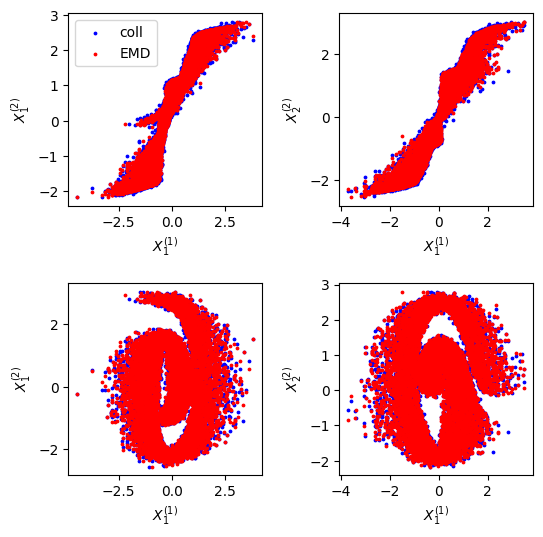

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

axes[0,0].scatter(X[0,:,0], X[1,:,0], color="blue", s=3, label="coll")
axes[0,0].scatter(x_emd[:,0], y_emd[:,0], color="red", s=3, label="EMD")
axes[0,0].set_xlabel(r"$X_1^{(1)}$")
axes[0,0].set_ylabel(r"$X_1^{(2)}$")

axes[0,1].scatter(X[0,:,1], X[1,:,1], color="blue", s=3)
axes[0,1].scatter(x_emd[:,1], y_emd[:,1], color="red", s=3)
axes[0,1].set_xlabel(r"$X_1^{(1)}$")
axes[0,1].set_ylabel(r"$X_2^{(2)}$")

axes[1,0].scatter(X[0,:,0], X[1,:,1], color="blue", s=3)
axes[1,0].scatter(x_emd[:,0], y_emd[:,1], color="red", s=3)
axes[1,0].set_xlabel(r"$X_1^{(1)}$")
axes[1,0].set_ylabel(r"$X_1^{(2)}$")

axes[1,1].scatter(X[0,:,1], X[1,:,0], color="blue", s=3)
axes[1,1].scatter(x_emd[:,1], y_emd[:,0], color="red", s=3)
axes[1,1].set_xlabel(r"$X_1^{(1)}$")
axes[1,1].set_ylabel(r"$X_2^{(2)}$")

axes[0,0].legend()
fig.subplots_adjust(wspace=0.4, hspace=0.4)

In [8]:
W2_col = np.mean( np.sum( (X[0,...]-X[1,...])**2, axis=-1 ) )
W2_emd = np.mean( np.sum( (x_emd-y_emd)**2, axis=-1 ) )
print("Relative error in estimating the Wasserstein distance is ", (W2_col-W2_emd)/W2_emd)

Relative error in estimating the Wasserstein distance is  0.011933110509744842
